In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

import statistics
import gc # Helps to clear up some ram

import cv2
from numpy import random
from imgaug import augmenters as img_aug

import math
import os

In [ ]:
import pickle

path = "/content/drive/My Drive/AutonomousDriving"
pickle_in = open(path+"/testColour.pickle","rb")
# Remove binary version
testImages = pickle.load(pickle_in)

imageId = []
X = []


for id,image in testImages:
  #checking = image
  if np.count_nonzero(pd.isnull(image)): 
    print("NA: This image was not read well so we will skip for now")
  else:
    imageId.append(id)
    X.append(image)

1016


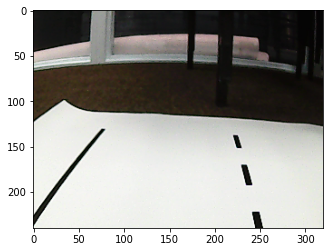

In [ ]:
print(imageId[0])
plt.imshow(X[0])

In [ ]:
X = np.array(X)
imageId = np.array(imageId)

In [ ]:
def img_preprocess(image):
    height, width, _ = image.shape

    # in the case that there exists an object in the image of interest DO NOT MAKE reduce the height of the image!!
    
    # image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0) # Gaussian Noise / filtering
    image = cv2.resize(image, (240,114))# Need to reduce  size to conserve memory
    image = cv2.resize(image, (0,0), fx=0.7, fy=0.7)# Need to reduce  size to conserve memory
    image = image / 255 # normalizing
    # Round everything into the image to 1 decimal place
    image = np.around(image ,2)
    return image

In [ ]:
X_final = []
for img_index in range(X.shape[0] ):
  X_f = img_preprocess(X[img_index,:,:,:])
  X_final.append(X_f)

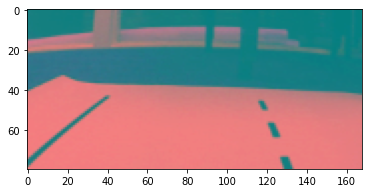

In [ ]:
plt.imshow(X_final[0])

In [ ]:
X_final=np.array(X_final)

remember to sort the test by its image id

In [ ]:
model = load_model(path+'/Speed_prediction_model.h5')

In [ ]:
speed = model.predict(X_final)

In [ ]:
speed= np.round(speed,0)

In [ ]:
# submissionFrame = pd.read_csv(path+"/Github/AutonomousCars/data/sampleSubmission.csv")

In [ ]:
submissionFrame.head()

,image_id,angle,speed
0,1,0.8125,1
1,2,0.0000,0
2,3,0.0000,0
3,4,1.0000,0
4,5,0.5625,0


In [ ]:
# submissionFrame["image_id"] = imageId

In [ ]:
# submissionFrame["angle"] = steering_angle

In [ ]:
submissionFrame["speed"] = speed

In [ ]:
submissionFrame.drop(['index'],inplace=True,axis='columns')

In [ ]:
submissionFrame.sort_values(by=['image_id'],inplace=True)

In [ ]:
submissionFrame.reset_index(inplace=True,drop=True)

In [ ]:
submissionFrame.head()

,image_id,angle,speed
0,1,0.521785,0.0
1,2,0.770591,1.0
2,3,0.201117,1.0
3,4,0.162088,1.0
4,5,0.077643,1.0


In [ ]:
%cd /content/drive/My Drive/AutonomousDriving/Github/AutonomousCars/data/

/content/drive/My Drive/AutonomousDriving/Github/AutonomousCars/data


In [ ]:
submissionFrame.sort_values(by=['image_id'])
# submissionFrame.reset_index(inplace=True)

In [ ]:
submissionFrame.to_csv("sampleSubmission.csv")

In [ ]:
submissionFrame.head()

,image_id,angle,speed
0,1,0.521785,0.0
1,2,0.770591,1.0
2,3,0.201117,1.0
3,4,0.162088,1.0
4,5,0.077643,1.0
